In [45]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import os
from model_utils import *
import scipy.stats as stats 
import numpy as np
import random
import statsmodels.stats.api as sms
from statsmodels.stats.multitest import multipletests

## Multi-Task Modeling Playground

The goal of this notebook is to prototype the modeling process for the team ingredient horse race project on the multi-task data.

For *each task* ...

We want to understand the effect of different "ingredients of a team" (Composition, Task, and Conversation) on its ultimate performance.

Team Composition:
- ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race']
- Number of players: 'playerCount'

Task Features:
- Need to append from the Task Map
- ['complexity', 'task']

Conversation Features (All)
- Everything else that is NOT an ID or a dependent variable

# Read and Preprocess Data
The function below reads in the dataframe and preprocesses each group of features:

- Composition
- Task
- Conversation

And also parses out the possible dependent variables.

In [2]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))


In [25]:
def read_and_preprocess_data(path, min_num_chats):
    conv_data  = pd.read_csv(path)

    # Fill NA with mean
    conv_data.fillna(conv_data.mean(), inplace=True) 

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]


    # Save the important information

    # DV
    dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min"]]

    # Team Composition
    composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
                'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level',
                'gender', 'marital_status', 'political_party', 'race', 'playerCount']
    
    # Select columns that contain the specified keywords
    composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

    # Task
    task = conv_data[['task', 'complexity']].copy()

    task_map_path = '../utils/task_map.csv' # get task map
    task_map = pd.read_csv(task_map_path)

    task_name_mapping = {
        "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
        "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
        "Guess the Correlation": "Guessing the correlation",
        "Writing Story": "Writing story",
        "Room Assignment": "Room assignment task",
        "Allocating Resources": "Allocating resources to programs",
        "Divergent Association": "Divergent Association Task",
        "Word Construction": "Word construction from a subset of letters",
        "Whac a Mole": "Whac-A-Mole"
    }
    task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
    task = pd.merge(left=task, right=task_map, on = "task", how='left')
    
    # Create dummy columns for 'complexity'
    complexity_dummies = pd.get_dummies(task['complexity'])
    task = pd.concat([task, complexity_dummies], axis=1)   
    task.drop(['complexity', 'task'], axis=1, inplace=True)

    # Conversation
    conversation = conv_data.drop(columns=list(dvs.columns) + list(composition.columns) + ['task', 'complexity', 'stageId', 'roundId', 'cumulative_stageId', 'gameId', 'message', 'message_lower_with_punc', 'speaker_nickname', 'conversation_num', 'timestamp'])
    conversation = drop_invariant_columns(conversation) # drop invariant conv features

    # experiment: drop lexical columns
    conversation = conversation.drop(columns=[col for col in conversation.columns if "lexical" in col], axis=1)

    # additional preprocess --- get PC's of conversation to reduce dimensionality issues
    pca = PCA(n_components=20)
    pca_result = pca.fit_transform(conversation.transform(lambda x: (x - x.mean()) / x.std()))
    print("PCA explained variance:")
    print(np.sum(pca.explained_variance_ratio_))
    conversation = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return composition, task, conversation, dvs

In [8]:
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

In [9]:
# PARAMETERS
min_num_chats = 0
desired_target = "score"
data_path = "../output/"
output_path = "./results/multi_task_cumulative_stage/" + "min=" + str(min_num_chats) + "/" + desired_target + "/"

In [26]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage, min_num_chats=min_num_chats)

# Number of points in dataset
len(conv_features)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


PCA explained variance:
0.6319643237290705


1018

# Set up X's and y's

In [27]:
X_train = pd.concat([team_composition_features, task_features, conv_features], axis = 1)
y_train = targets

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



Two updates to make here:

1. For nested LASSO/Ridge models, add the ability to initialize the model using the previous weights
2. Visualize importance using another library, like SHAP

In [11]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [12]:
def fit_regularized_linear_model(X_train, y_train, y_target, feature_columns_list, lasso=True, tune_alpha=False, prev_coefs = None, prev_alpha = None):

    if not tune_alpha:
        alpha = 1.0
    if (prev_alpha is not None):
        alpha = prev_alpha # use previous alpha
        print("Setting alpha to previous...")
        print(alpha)
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    if(prev_coefs is not None): # set weights to previous coefficients
        print("Setting coefficients ....")
        model.coef_ = prev_coefs

        print(model.coef_)

    # Calculation of Q^2 metric
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # Initialize a list to store coefficients
    coefficients_list = []

    # Leave one out -- iterate through the entire length of the dataset
    for i in range(len(y_train)):
        # Store the evaluation datapoint
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        # Drop the ith datapoint (leave this one out)
        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        coefficients_list.append(model.coef_)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients


In [13]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return summary_df

In [14]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

In [15]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "q_squared": []
}

result_df = pd.DataFrame(result)

# Function to Run all Experiments in 1 Go

In [29]:
def get_sample_with_replacement(df):
    num_rows = len(df)
    resampled_indices = pd.Series(range(num_rows)).sample(n=num_rows, replace=True).reset_index(drop=True)
    resampled_dataframe = df.iloc[resampled_indices]

    return resampled_dataframe

In [30]:
def resample():
    total_data = pd.concat([X_train, y_train], axis = 1)
    resampled_data = get_sample_with_replacement(total_data)
    resampled_X_train = resampled_data[list(X_train.columns)]
    resampled_y_train = resampled_data[list(y_train.columns)]

    return resampled_X_train, resampled_y_train

In [31]:
def train_and_evaluate_three_models(random_seed):
    random.seed(random_seed)

    # Set up the dataset by drawing 1,000 samples
    resampled_X_train, resampled_y_train = resample()

    # Composition Features
    model_ridge_composition, mrc_q2, mrc_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

    # Composition + Task
    task_comp_features = list(task_features.columns) + list(team_composition_features.columns)
    model_ridge_taskcomp, mrtc_q2, mrtc_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, task_comp_features, lasso = False, tune_alpha = True)

    # Composition + Task + Conversation
    all_features = list(task_features.columns) + list(team_composition_features.columns) + list(conv_features.columns)
    model_ridge_all, mrall_q2, mrall_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, all_features, lasso = False, tune_alpha = True)

    return mrc_q2, mrtc_q2, mrall_q2

In [32]:
composition_only = []
composition_task = []
all = []
random_seeds = np.random.randint(999999999999, size=20)

for seed in random_seeds: # bootstrap 20 times
    comp, taskcomp, taskcompconv = train_and_evaluate_three_models(seed)
    composition_only.append(comp)
    composition_task.append(taskcomp)
    all.append(taskcompconv)

Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.12775782505021316
Q^2: 0.24221931859314916
Q^2: 0.09165992891017505


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.09469336253387961
Q^2: 0.18317987220140097
Q^2: 0.08648172904480445


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.1335761909183809
Q^2: 0.20903152370619715
Q^2: 0.02042748518698534


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.07154225760023047
Q^2: 0.2102316747779408
Q^2: 0.19800820849781775


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.10697909288823693
Q^2: 0.22044907627932053
Q^2: 0.2104610840509844


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.11763993881519397
Q^2: 0.23698421736476338
Q^2: 0.21988915999871272


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.11774292890480265
Q^2: 0.26085934567553004
Q^2: 0.07102377917393943


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.04934288324659164
Q^2: 0.06944837670713366
Q^2: 0.06985968476421345


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.10940302194321472
Q^2: 0.25308533658845367
Q^2: 0.27366207981305024


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.14412593557673814
Q^2: 0.2630629704963626
Q^2: 0.007383598710319905


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.13143765660540419
Q^2: 0.2636025637306959
Q^2: -0.015084078365373621


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.1091879716877513
Q^2: 0.25694422209460377
Q^2: 0.26401840388863396


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.09032030287630621
Q^2: 0.2246073190707183
Q^2: 0.25259781557519356


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.039985534658930844
Q^2: 0.04159908295349757
Q^2: 0.08119494952729811


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.05030681609662879
Q^2: 0.0520630187618788
Q^2: 0.08229793354667736


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.11654524537191024
Q^2: 0.2488706075986138
Q^2: -0.26761750492927705


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.06154815002650804
Q^2: 0.11201234592274367
Q^2: 0.10816418678327322


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.06438871886690323
Q^2: 0.06633153256437974
Q^2: 0.08612654122661079


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.14809254668662786
Q^2: 0.2505669545026916
Q^2: 0.26914246457751123


Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.


Q^2: 0.034769745925977036
Q^2: 0.036801944651685514
Q^2: 0.05377629062125533


In [33]:
sms.DescrStatsW(composition_only).tconfint_mean()

(0.07915873724414574, 0.11277987538389725)

In [34]:
sms.DescrStatsW(composition_task).tconfint_mean()

(0.1450389244365196, 0.22515620598765645)

In [35]:
sms.DescrStatsW(all).tconfint_mean()

(0.048184768544317684, 0.16816260551596285)

In [124]:
def plot_means_with_confidence_intervals_and_ttests(observation_lists, labels, confidence_level=0.95, alpha=0.05):
    # Calculate means and confidence intervals
    means = [np.mean(observation) for observation in observation_lists]
    errors = [(sms.DescrStatsW(observation).tconfint_mean()[1]-sms.DescrStatsW(observation).tconfint_mean()[0])/2. for observation in observation_lists]
    colors = plt.cm.tab20(np.arange(len(labels)))

    # Plot the bar graph with error bars
    plt.bar(range(len(means)), means, yerr=errors, align='center', alpha=0.7, ecolor='black', color = colors, capsize=10)
    
    # Add labels and title
    plt.xticks(range(len(means)), labels)
    plt.xlabel('Model')
    plt.ylabel('Prediction Q^2')
    plt.title('Predictive Power of Models; Pairwise t-test with B-H Correction')

    # Perform pairwise t-tests
    p_values = []
    line_height = np.mean(max(observation_lists))*0.1
    for i in range(len(observation_lists)):
        for j in range(i + 1, len(observation_lists)):
            t_stat, p_value = stats.ttest_ind(observation_lists[i], observation_lists[j])
            p_values.append(p_value)

            # Draw horizontal bar between compared groups
            line_y = max(means) + max(errors) + np.mean(max(observation_lists))*0.03 + (i + j) * line_height
            plt.plot([i, j], [line_y, line_y], color='black')

            # Display significance stars or 'n.s.' based on corrected p-values
            significance_label = '*' if p_value < alpha else 'n.s.'

            # Display significance labels on the plot
            plt.text((i + j) / 2, line_y + np.mean(max(observation_lists))*0.05, significance_label, ha='center', va='center')

    # Correct p-values for multiple comparisons using Benjamini-Hochberg procedure
    _, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

    # Show the plot
    plt.show()

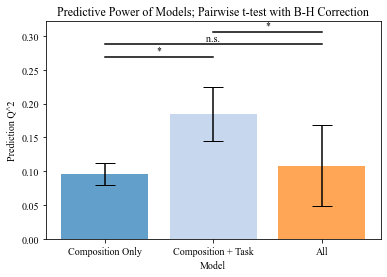

In [123]:
plot_means_with_confidence_intervals_and_ttests([composition_only, composition_task, all], ["Composition Only", "Composition + Task", "All"])

# Dataframe that summarizes all these experiments!

In [219]:
result_df.sort_values(by = "q_squared", ascending = False)

,model,model_type,features_included,alpha,q_squared
2,Ridge(alpha=0.002904485249183131),Ridge,All Features,0.0029,1.00000
1,Ridge(alpha=0.002904485249183131),Ridge,Team Composition + Task Complexity,0.0029,0.67973
0,Ridge(alpha=0.011839413838757983),Ridge,Team Composition,0.0118,0.49604


# Feature Importance

In [ ]:
sort_by_mean_abs(display_feature_coefficients(mrall_feature_coefficients))

In [ ]:
def plot_top_n_features(data, n, filepath):
    # Calculate the absolute mean value and sort the DataFrame in descending order
    data['Absolute_Mean'] = data['Mean'].abs()
    top_n_features = data.sort_values(by='Absolute_Mean', ascending=False).head(n)

    # Define color mapping for the features
    color_map = {}
    name_map = {}
    for feature in task_features.columns:
        color_map[feature] = 'yellowgreen'
        name_map[feature] = "Task Feature"
    for feature in conv_features.columns:
        color_map[feature] = 'powderblue'
        name_map[feature] = "Conversation Feature"
    for feature in team_composition_features.columns:
        color_map[feature] = 'lightpink'
        name_map[feature] = "Team Composition Feature"

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    handles = []

    for feature in top_n_features['Feature']:
        color = color_map.get(feature, 'k')  # Default to black if not in any list
        bars = plt.barh(feature, top_n_features[top_n_features['Feature'] == feature]['Mean'], color=color)
        handles.append(bars[0])

    # Customize the plot
    plt.xlabel('Mean Coefficient (Across LOO Cross Validation)', fontsize = 14)
    plt.title(f'Top {n} features for {desired_target} (min chats = {min_num_chats})', fontsize=20)
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest value at the top

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Create a legend outside the plot area with unique labels
    unique_features = []
    unique_labels = []
    for feature in top_n_features['Feature']:
        if name_map.get(feature, feature) not in unique_labels:
            unique_labels.append(name_map.get(feature, feature))
            unique_features.append(feature)

    legend_handles = [plt.Line2D([0], [0], color=color_map.get(feature, 'k'), lw=4, label=name_map.get(feature, feature)) for feature in unique_features]
    plt.legend(handles=legend_handles, loc='center left', fontsize = 14, bbox_to_anchor=(1, 0.5))

    # Add labels to the bars with increased text size and Mean rounded to 2 decimals, consistently inside the bar
    label_offset = 0.4  # Adjust this value for proper spacing
    for bar, value, feature in zip(handles, top_n_features['Mean'], top_n_features['Feature']):
        label_x = (max(value, 0) if value >= 0 else min(value, 0))
        bbox = bar.get_bbox()
        label_y = bbox.bounds[1] + label_offset
        if value >= 0:
            plt.text(label_x, label_y, f'{value:.2f}', va='center', fontsize=12)
        else:
            plt.text(label_x, label_y, f'{value:.2f}', ha='right', va='center', fontsize=12)

    # Show the plot
    plt.savefig(filepath + ".svg")
    plt.savefig(filepath + ".png")
    plt.show()

In [ ]:
plot_top_n_features(display_feature_coefficients(mlall_feature_coefficients), 10, filepath = "./figures/multi_task_cumulative_stage" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats))

Questions:
- More deeply understand difference between LASSO and Ridge
- Better understand `alpha` hyperparameter
- Why doesn't more features mean a better R^2? (Wouldn't the model 'throw out' features that don't work?)